# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Познакомимся с данными, выведем на экран первых 20 строк:

In [3]:
df.head(20)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Произведем поиск дубликатов:

In [4]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Удалим найденные дубликаты

In [5]:
df = df.drop_duplicates().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  NotRepaired        283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Ввиду того, что невозможно корректно восстановить пропущенные значения в столбцах 'VehicleType', 'Gearbox','Model', 'FuelType', 'NotRepaired' заменим их на значения unknown

In [7]:
na_list = ['VehicleType','Gearbox','Model','FuelType','NotRepaired']
for item in na_list:
    df[item] = df[item].fillna(value='unknown')
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Пропуски исчезли, теперь уберем признаки, которые не пригодятся при прогнозировании, такие как различные даты анкет, месяц регистрации авто(оставим только год), количество фото и почтовый индекс.

In [8]:
df = df.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'],axis=1)

In [9]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       354365 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           354365 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             354365 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          354365 non-null  object
 8   Brand             354365 non-null  object
 9   NotRepaired       354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [10]:
for value in df.columns:
    print('Количество значений признака ',value,len(df[value].unique()))

Количество значений признака  Price 3731
Количество значений признака  VehicleType 9
Количество значений признака  RegistrationYear 151
Количество значений признака  Gearbox 3
Количество значений признака  Power 712
Количество значений признака  Model 251
Количество значений признака  Kilometer 13
Количество значений признака  FuelType 8
Количество значений признака  Brand 40
Количество значений признака  NotRepaired 3


Создадим списки признаков таблицы: количественный и категориальный.
Изучим значения количественных признаков, избавимся от быбросов.

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

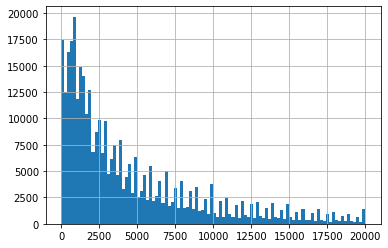

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

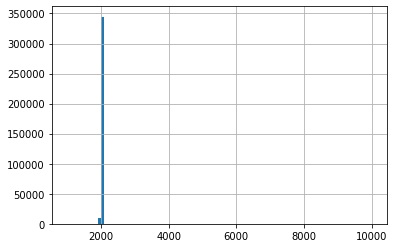

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

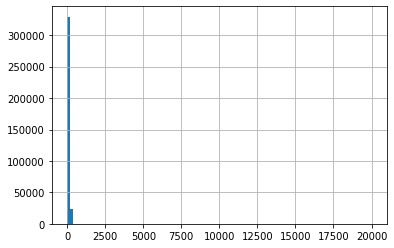

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

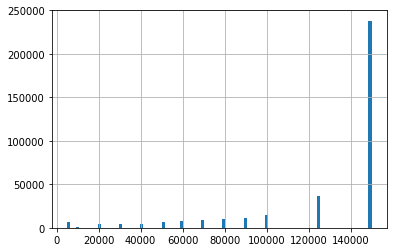

In [11]:
numerical_list=['Price','RegistrationYear','Power','Kilometer']
category_list = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
for value in numerical_list:
    display(df[value].describe())
    df[value].hist(bins=100)
    plt.show()

В столбце Цена присутствуют нулевые значения, подсчитаем их количество

In [12]:
df[df['Price']==0].count()

Price               10772
VehicleType         10772
RegistrationYear    10772
Gearbox             10772
Power               10772
Model               10772
Kilometer           10772
FuelType            10772
Brand               10772
NotRepaired         10772
dtype: int64

10772 значения не имеют нулевую цену, что составляет 3% от общего количества значений в таблице. Поскольку нам предстоит прогнозирование цены, а это стоит делать на основе имеющихся фактических данных, а не предположительно-расчетных, поэтому  удалим нулевые значения цены. Крайне низкие значения цен оставим, т.к. часто авто продаются за символическую сумму- продавцы хотят избавиться от старого или разбитого авто.

In [13]:
df = df.loc[df['Price'] != 0]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343593 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343593 non-null  int64 
 1   VehicleType       343593 non-null  object
 2   RegistrationYear  343593 non-null  int64 
 3   Gearbox           343593 non-null  object
 4   Power             343593 non-null  int64 
 5   Model             343593 non-null  object
 6   Kilometer         343593 non-null  int64 
 7   FuelType          343593 non-null  object
 8   Brand             343593 non-null  object
 9   NotRepaired       343593 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.8+ MB


В столбце Год регистрации присутствуют разничные значения, кажущиеся некорректными. Для визуальной оценки отобразим эти значения в ввиде списка, осортировав их по возрастанию

In [15]:
sorted(df['RegistrationYear'].unique())

[1000,
 1001,
 1039,
 1111,
 1234,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7800,
 8000,
 8200,
 8500,
 8888,
 9000,
 9450,
 9999]

Очевидно, что в столбце Год регистрации присутвуют некорректные значения. Первые автомобили появились в начале ХХ века, предположим, что раритетные автомобили присутсвуют в базе. А значит все указанные года ниже 1910 года - это некорректные значения. То же самое и с годами регистрации более 2019 года. Подсчитаем количество таких значений, если оно мало (менее 10000 значений), удалим их

In [16]:
df[(df['RegistrationYear'] < 1910) | (df['RegistrationYear'] > 2019)]['RegistrationYear'].count()

139

Количество некорректных значений крайне мало, поэтому удаляем их

In [17]:
df = df.loc[(df['RegistrationYear'] >= 1910) & (df['RegistrationYear'] <= 2016)]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329761 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             329761 non-null  int64 
 1   VehicleType       329761 non-null  object
 2   RegistrationYear  329761 non-null  int64 
 3   Gearbox           329761 non-null  object
 4   Power             329761 non-null  int64 
 5   Model             329761 non-null  object
 6   Kilometer         329761 non-null  int64 
 7   FuelType          329761 non-null  object
 8   Brand             329761 non-null  object
 9   NotRepaired       329761 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.7+ MB


В столбце мощность присутствует явный выбросы. Учитывая, что на сегодня самым мощным автомобилем в мире является электрический гиперкар Owl от японской компании Aspark с мощностью двигателя 2012 л.с.(Источник: https://www.clickme.com.ru/cars/reyting-samyih-moschnyih-v-mire-avtomobiley.html), посчитаем количество значений-выбросов более чем 2012 лс и удалим их

In [19]:
display(df[df['Power']>2012].count())
df = df.loc[df['Power'] <=2012]
df.info()

Price               99
VehicleType         99
RegistrationYear    99
Gearbox             99
Power               99
Model               99
Kilometer           99
FuelType            99
Brand               99
NotRepaired         99
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329662 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             329662 non-null  int64 
 1   VehicleType       329662 non-null  object
 2   RegistrationYear  329662 non-null  int64 
 3   Gearbox           329662 non-null  object
 4   Power             329662 non-null  int64 
 5   Model             329662 non-null  object
 6   Kilometer         329662 non-null  int64 
 7   FuelType          329662 non-null  object
 8   Brand             329662 non-null  object
 9   NotRepaired       329662 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.7+ MB


In [20]:
for value in category_list:
    display(value, sorted(df[value].unique()))

'VehicleType'

['bus',
 'convertible',
 'coupe',
 'other',
 'sedan',
 'small',
 'suv',
 'unknown',
 'wagon']

'Gearbox'

['auto', 'manual', 'unknown']

'Model'

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

'FuelType'

['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol', 'unknown']

'Brand'

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

'NotRepaired'

['no', 'unknown', 'yes']

В столбце Мобель найдены схожие названия "range_rover" и "rangerover".
Посчитаем их количество и объединим их.

В столбце Топливо присутствуют значения 'gasoline' и 'petrol', что означает "бензин" объединим и эти значения

In [21]:
display(df[df['Model']=='range_rover']['Model'].count())
display(df[df['Model']=='rangerover']['Model'].count())
display(df[df['FuelType']=='gasoline']['FuelType'].count())
display(df[df['FuelType']=='petrol']['FuelType'].count())

75

3

94827

204657

In [22]:
df['Model'] = df['Model'].str.replace('rangerover','range_rover')
df['FuelType'] = df['FuelType'].str.replace('gasoline','petrol')

В таблице присутствуют значения признаков со статусом unknown, без которых сложно будет идентифицировать авто. Основным таким признаком является Модель автомобиля. Подсчитаем количество пропущенных значений признака Модель авто.

In [23]:
display(df[df['Model']=='unknown']['Model'].count())

15625

17455 значений это 5% от всех значений в таблице. Удалим эти строки

In [24]:
df = df.loc[df['Model'] != 'unknown'].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314037 entries, 0 to 314036
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             314037 non-null  int64 
 1   VehicleType       314037 non-null  object
 2   RegistrationYear  314037 non-null  int64 
 3   Gearbox           314037 non-null  object
 4   Power             314037 non-null  int64 
 5   Model             314037 non-null  object
 6   Kilometer         314037 non-null  int64 
 7   FuelType          314037 non-null  object
 8   Brand             314037 non-null  object
 9   NotRepaired       314037 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.0+ MB


После произведенных изменений в таблице могли образоваться дубли, произведем их поиск и удаление

In [25]:
df[df.duplicated()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
990,950,small,1999,manual,60,polo,150000,petrol,volkswagen,no
2509,1499,small,2001,manual,58,corsa,150000,petrol,opel,no
2676,2800,wagon,2005,unknown,0,touran,150000,petrol,volkswagen,no
3053,300,small,2000,manual,54,corsa,150000,petrol,opel,unknown
3137,1670,sedan,1999,manual,75,golf,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
314022,6500,sedan,2003,auto,145,e_klasse,150000,petrol,mercedes_benz,no
314025,4400,sedan,2008,manual,105,leon,150000,petrol,seat,no
314028,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
314029,7900,sedan,2010,manual,140,golf,150000,petrol,volkswagen,no


In [26]:
df = df.drop_duplicates().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271704 entries, 0 to 271703
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             271704 non-null  int64 
 1   VehicleType       271704 non-null  object
 2   RegistrationYear  271704 non-null  int64 
 3   Gearbox           271704 non-null  object
 4   Power             271704 non-null  int64 
 5   Model             271704 non-null  object
 6   Kilometer         271704 non-null  int64 
 7   FuelType          271704 non-null  object
 8   Brand             271704 non-null  object
 9   NotRepaired       271704 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.7+ MB


Для задач обучения необходимо категориальные признаки преобразовать в численные. Поскольку количество значений категориальных признаков велико, используем метод порядкового кодирования.
Для начала выделим из финального датафрейма промежуточный датафрейм с категориальными признакми, к которому применим порядковое кодирование.

In [27]:
obj_df = df.select_dtypes(include=['object']).copy()
display(obj_df)

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,unknown,manual,golf,petrol,volkswagen,unknown
1,suv,auto,grand,petrol,jeep,unknown
2,small,manual,golf,petrol,volkswagen,no
3,small,manual,fabia,petrol,skoda,no
4,sedan,manual,3er,petrol,bmw,yes
...,...,...,...,...,...,...
271699,unknown,auto,159,unknown,alfa_romeo,no
271700,sedan,manual,leon,petrol,seat,yes
271701,convertible,auto,fortwo,petrol,smart,no
271702,bus,manual,transporter,petrol,volkswagen,no


In [28]:
obj_df = pd.DataFrame(OrdinalEncoder().fit_transform(obj_df),columns=obj_df.columns)
obj_df

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,7.0,1.0,116.0,5.0,37.0,1.0
1,6.0,0.0,117.0,5.0,14.0,1.0
2,5.0,1.0,116.0,5.0,37.0,0.0
3,5.0,1.0,101.0,5.0,31.0,0.0
4,4.0,1.0,11.0,5.0,2.0,2.0
...,...,...,...,...,...,...
271699,7.0,0.0,4.0,6.0,0.0,0.0
271700,4.0,1.0,140.0,5.0,30.0,2.0
271701,1.0,0.0,106.0,5.0,32.0,0.0
271702,0.0,1.0,223.0,5.0,37.0,0.0


In [29]:
df_ordinal= obj_df.join(df.select_dtypes(include=['int64']).copy()) # объеденим закодированный датафрейм с датафреймом с количественными признаками
df_ordinal = df_ordinal.astype('int64') # преобразуем все значения в целочисленные
df_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271704 entries, 0 to 271703
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   VehicleType       271704 non-null  int64
 1   Gearbox           271704 non-null  int64
 2   Model             271704 non-null  int64
 3   FuelType          271704 non-null  int64
 4   Brand             271704 non-null  int64
 5   NotRepaired       271704 non-null  int64
 6   Price             271704 non-null  int64
 7   RegistrationYear  271704 non-null  int64
 8   Power             271704 non-null  int64
 9   Kilometer         271704 non-null  int64
dtypes: int64(10)
memory usage: 20.7 MB


In [30]:
features = df_ordinal.drop(['Price'],axis=1)
target = df_ordinal['Price']
features_train, features_valid, target_train, target_valid = train_test_split(
    features,target, test_size=0.25, random_state=12345)
print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)

(203778, 9) (67926, 9) (203778,) (67926,)


## Обучение моделей

Произведем обученине моделей. Для подбора параметров используем инструмент GridSearchCV.
Замерим время выполнения каждого метода.
Параметры моделей заранее подобраны таким образом, чтобы время обучения было минимальным при рассчитанной минимальной RSME.

Начинаем с метода <b>Дерево решений</b>:

In [31]:
model_dt= DecisionTreeRegressor(random_state=12345)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(10,11)
}
gsearch = GridSearchCV(model_dt, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=2)
dt_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-dt_model.best_score_} при параметрах {dt_model.best_params_}')

Лучшая RMSE: 1943.1579252938184 при параметрах {'max_depth': 15, 'min_samples_leaf': 10}


<b>Случайный Лес:</b>

In [32]:

model_rf= RandomForestRegressor(random_state=12345)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(2,3)
}
gsearch = GridSearchCV(model_rf, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=2)
rf_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-rf_model.best_score_} при параметрах ,{rf_model.best_params_}')

Лучшая RMSE: 1749.8348281482627 при параметрах ,{'max_depth': 15, 'min_samples_leaf': 2}


<b>Линейная регрессия:</b>

<font color='purple'>Для линейной регресии используем технику прямого кодирования категориальный признаков</font>

In [33]:
df_ohe = pd.get_dummies(df, drop_first=True)

display(df_ohe)
df_ohe.info()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,3600,2008,69,90000,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271699,5250,2016,150,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271700,3200,2004,225,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
271701,1199,2000,101,125000,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
271702,9200,1996,102,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271704 entries, 0 to 271703
Columns: 308 entries, Price to NotRepaired_yes
dtypes: int64(4), uint8(304)
memory usage: 87.1 MB


Разобьем данные на обучающую, тестовую выборки.

In [34]:
features1 = df_ohe.drop(['Price'],axis=1)
target1 = df_ohe['Price']
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
    features1,target1, test_size=0.25, random_state=12345)
print(features_train1.shape, features_valid1.shape, target_train1.shape, target_valid1.shape)

(203778, 307) (67926, 307) (203778,) (67926,)


In [35]:

model_lr = LinearRegression() 
model_lr.fit(features_train1, target_train1)
 
predictions = model_lr.predict(features_valid1)  
print("RMSE:",mean_squared_error(target_valid1,predictions,squared= False))

RMSE: 2783.0609150190285


In [36]:
RSME_dt = -cross_val_score(model_dt, features_train, target_train, scoring='neg_root_mean_squared_error', cv=5).mean()
RSME_rf = -cross_val_score(model_rf, features_train, target_train, scoring='neg_root_mean_squared_error', cv=5).mean()
RSME_lr = -cross_val_score(model_lr, features_train1, target_train1, scoring='neg_root_mean_squared_error', cv=5).mean()
print(RSME_dt,RSME_rf,RSME_lr)

2119.3363662536212 1719.1005723556614 2795.342234493616


Таким образом мы получили минимальную метрику RSME= 1719 при обучении модели методом Случайный Лес.

## Анализ моделей

Произведем обученине моделей методом LightGBM.
Для этого метода не требуется кодирование категориальных признаков, поэтому разобьем исходный датафрейм на обучающую и валидационную выборки. Дли применения метода необходимо изменить тип данных значений категориальных признаков на 'category'

In [37]:
features2 = df.drop(['Price'],axis=1)
target2 = df['Price']
features2[category_list] = features2[category_list].astype('category')
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
    features2,target2, test_size=0.25, random_state=12345)
#display(features_train2[category_list])
#print(category_list)
features_train2.info()
print(features_train2.shape, features_valid2.shape, target_train2.shape, target_valid2.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203778 entries, 160746 to 217570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       203778 non-null  category
 1   RegistrationYear  203778 non-null  int64   
 2   Gearbox           203778 non-null  category
 3   Power             203778 non-null  int64   
 4   Model             203778 non-null  category
 5   Kilometer         203778 non-null  int64   
 6   FuelType          203778 non-null  category
 7   Brand             203778 non-null  category
 8   NotRepaired       203778 non-null  category
dtypes: category(6), int64(3)
memory usage: 7.6 MB
(203778, 9) (67926, 9) (203778,) (67926,)


Замерим время обучения методом LightGBM
Параметры модели заранее подобраны таким образом, чтобы время обучения было минимальным при рассчитанной минимальной RSME.

In [38]:

model_lgbm= LGBMRegressor(random_state=12345, n_jobs=2)

param_grid = {
    "max_depth" : range(15,16),
    "n_estimators" : range(900,901)
}

gsearch = GridSearchCV(model_lgbm, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=2)
lgb_model = gsearch.fit(features_train2,target_train2)
print(f'Лучшая RMSE: {-lgb_model.best_score_} при параметрах ,{lgb_model.best_params_}')

Лучшая RMSE: 1616.3449408673132 при параметрах ,{'max_depth': 15, 'n_estimators': 900}


 Проведем финальные тесты, замерив время обучения модели, время рабты можели и RSME на тестовых данных

In [39]:
st_dt = time.time()
dt_model_test = dt_model.fit(features_train,target_train)
st_dt1 = time.time()
dt_predictions = dt_model_test.predict(features_valid)
RSME_dt_test = mean_squared_error(target_valid, dt_predictions,squared= False)
st_dt2 = time.time()
learn_time_dt = st_dt1-st_dt
pred_time_dt = st_dt2-st_dt1

In [40]:
st_rf = time.time()
rf_model_test = rf_model.fit(features_train,target_train)
st_rf1 = time.time()
rf_predictions = rf_model_test.predict(features_valid)
RSME_rf_test = mean_squared_error(target_valid, rf_predictions,squared= False)
st_rf2 = time.time()
learn_time_rf = st_rf1-st_rf
pred_time_rf = st_rf2-st_rf1

In [41]:
st_lr = time.time()
lr_model_test = model_lr.fit(features_train1,target_train1)
st_lr1 = time.time()
lr_predictions = lr_model_test.predict(features_valid1)
RSME_lr_test = mean_squared_error(target_valid1, lr_predictions,squared= False)
st_lr2 = time.time()
learn_time_lr = st_lr1-st_lr
pred_time_lr = st_lr2-st_lr1

In [42]:
st_lgb = time.time()
lgb_model_test = lgb_model.fit(features_train2,target_train2)
st_lgb1 = time.time()
lgb_predictions = lgb_model_test.predict(features_valid2)
RSME_lgb_test = mean_squared_error(target_valid2, lgb_predictions,squared= False)
st_lgb2 = time.time()
learn_time_lgb = st_lgb1-st_lgb
pred_time_lgb = st_lgb2-st_lgb1

In [43]:
data1 = {'Model':['DecisionTree', 'RandomForest', 'LinearRegression', 'LGBMRegressor'],'RSME': [RSME_dt_test, RSME_rf_test, RSME_lr_test, RSME_lgb_test], 'learn_time': [learn_time_dt, learn_time_rf, learn_time_lr, learn_time_lgb], 'predict_time': [pred_time_dt, pred_time_rf, pred_time_lr, pred_time_lgb]} 
pd.DataFrame(data1)

,Model,RSME,learn_time,predict_time
0,DecisionTree,1880.221210,1.199871,0.013624
1,RandomForest,1710.918465,79.104715,1.275404
2,LinearRegression,2783.060915,80.987750,0.208381
3,LGBMRegressor,1590.849309,37.894074,5.273145


Лучшее качество модели у метода LGBM, по сравнению с методом Случайный Лес время обучения обучения и предсказания значительно меньше

## Финальный вывод

Для сервиса по продаже автомобилей с пробегом «Не бит, не крашен» была получена и обработана информация о клиентах(данные приведены в надлежащий вид: убраны некорректные значения, дубликаты).  

Для определения стоимости были построены 4 модели предсказания. Самой эффективной моделью, которая показала минимальную метрику RSME и минимальное время обучения и предсказания, а значит и максимальную скорость, является модель градиентного бустинга библиотеки LightGBM.